Pre-algoritmo

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import networkx as nx

1. GENERACIÓN MATRIZ M

In [4]:
# 1.1 Leer el archivo CSV sin cabecera
df = pd.read_csv('BACI_HS92_Y2022_V202501.csv', sep=',', header=0)
year = 2022

Contenido de BACI_HS92_Y2023_V202501.csv:

Productos en nomenclatura de 6 dígitos del Sistema Armonizado.
Flujos comerciales a nivel de año - exportador - importador - producto.

t, 1ª columna, año

i, 2ª columna, país exportador

j, 3ª columna, país importador

k, 4ª columna, producto

v, 5ª columna, volumen de producto intercambiado (toneladas métricas)

q, 6ª columna, valor monetario de la transacción (Cientos de dólares)

In [5]:
# 1.2. Agrupar los productos, k, para quedarse con los primeros 4 dígitos.
df['k'] = df['k'].apply(lambda x: str(x)[:4])  # Convertir 'k' a string antes de aplicar el slicing

In [6]:
# 1.3. Crear la matriz usando pivot_table para manejar entradas duplicadas
M = df.pivot_table(index='i', columns='k', values='q', aggfunc='sum')

# Reemplazar NaN por 0 en la matriz resultante
M = M.fillna(0)

# Convertir la matriz M a un DataFrame de pandas para facilitar su manipulación
M = pd.DataFrame(M, index=M.index, columns=M.columns)

Balassa‐type “Revealed Comparative Advantage” (RCA) index

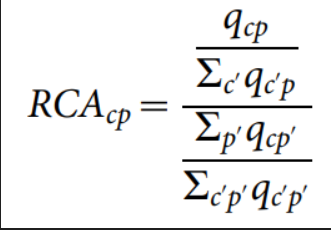

q_cp: quantity (e.g. exports) of product k by country i.

Divided by total quantity of product k across all countries.

Divided by total quantity of all products by country i.

Dividded by total quantity of all products across all countries.

El criterio del filtro no es cantidad exportada, sino valor de la cantidad exportada. Si un país regala productos, no afecta en su "economía".

In [7]:
# 1.4. Cálculos para RCA.
# Calcula el RCA_cp para cada elemento de la matriz q y lo sustituye en M.
c, p = M.shape
M_rca = np.zeros((c-1, p-1), dtype=float)  # Inicializa la matriz RCA_cp con ceros

In [8]:
suma_total = M.to_numpy().sum()  # Convertir M a un array NumPy para sumar
for i in range(c-1):
    for j in range(p-1):
        suma_columna = M.iloc[:, j].sum()
        suma_fila = M.iloc[i, :].sum()
        if suma_columna == 0 or suma_fila == 0:
            M_rca[i, j] = 0  # Evitar división por cero
        else:
            M_rca[i, j] = (M.iloc[i, j] / suma_columna) * (suma_total / suma_fila)

In [9]:
# 1.5. Filtro y actualización de M.
for i in range(c-1):
    for j in range(p-1):
        M.iloc[i, j] = np.where(M_rca[i, j] >= 1, 1, 0)

In [10]:
# Reordenar M
# Convertir M a un DataFrame si es un array de NumPy
if isinstance(M, np.ndarray):
	M = pd.DataFrame(M)

# Ordenar las filas y columnas de M según la suma de sus valores
M = M.loc[M.sum(axis=1).sort_values(ascending=False).index, M.sum(axis=0).sort_values(ascending=False).index]

ALGORITMO

Notación

A^{n}: Vector de la variable A en la iteración n.
Ag^{n}: Vector de la variable no normalizada A en la iteración n. (Variable intemedia de iteración).
B_c^{n}: Componente c de la variable B en la iteración n.

Declaración de variables
F: Vector de la Competitividad normalizada.
Q: Vector de la Complejidad normalizadas.
F_valores: Matriz que guarda los valores de F en cada iteración.
Q_valores: Matriz que guarda los valores de Q en cada iteración.

Consideraciones sobre las Condiciones iniciales:
Para el paso previo de calcular Fg^{n} y Qg^{n}, es necesario haber normalizado F^{n-1} y Q^{n-1}. 
Se toma A^{n} = 0 para el caso de Ag^{n-1} = 0.

Para calcular las variables intermedias Fg^{1} y Qg^{1}, se calculan primero F^{0} y Q^{0}.

In [11]:
#Condiciones iniciales.
Fg = np.ones(c)
Qg = np.ones(p)
# Condiciones iniciales normalizadas.
F = Fg / np.mean(Fg)
Q = Qg / np.mean(Qg)

In [12]:
# Definimos el número de iteraciones.
n = 100
# Definir la transpuesta de la matriz M
M_T = M.T

# Generamos la matriz que va a guardar los valores.
F_valores = np.zeros((n, c))
Q_valores = np.zeros((n, p))

for i in range(n):
    # 1) Cálculo de las variables intermedias:
    # Cálculo paso a paso de los productos matriciales.
    invF = np.zeros(c) # Inicializamos el vector invF[c] = 0
    for c_idx in range(c):
    # 1.1) Cálculo de Fg en la iteración n:
        Fg[c_idx] = np.sum(M.iloc[c_idx, :] * Q)
    # 1.2) Cálculo de Qg en la iteración n:
        # invF[c_idx] = 1.0 / F[c_idx] # donde invF[c] = 1 / F[c]
        if F[c_idx] == 0:
            invF[c_idx] = 0
        else:
            invF[c_idx] = 1.0 / F[c_idx]
    invQ = np.zeros(p) # Inicializamos el vector invQ[p] = 0
    for p_idx in range(p):
        invQ[p_idx] = np.sum(M_T.iloc[p_idx, :] * invF) # Fg[p] = \sum_c M_{c,p} * (1/F[c])
        if invQ[p_idx] == 0:
            Qg[p_idx] = 0
        else:
            Qg[p_idx] = 1.0 / invQ[p_idx]
    
    # # (No se queda este párrafo)
    # # Cálculos sin hacer paso a paso los productos matriciales.
    # Fg = np.dot(M, Q) # donde Fg[c] = \sum_p M_{c,p} * Q[p]
    # invF = 1.0 / F # donde invF[c] = 1 / F[c]
    # invQ = np.dot(M.T, invF) # donde Qg[p] = \sum_c M_{c,p} * (1/F[c])
    # Qg = 1.0 / invQ # np.where(invQ != 0, 1.0 / invQ, 0) # donde Qg[p] = 1 / \sum_c ( M_{c,p} / F_c^{(n-1)} )

    # 3) Normalización de y actualización de F y Q para la siguiente iteración.
    F = Fg / np.mean(Fg)
    Q = Qg / np.mean(Qg)

    # 4) Guardar los valores de F y Q en cada iteración para su posterior análisis/representación.
    F_valores[i, :] = F
    Q_valores[i, :] = Q

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_11616\1273093739.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


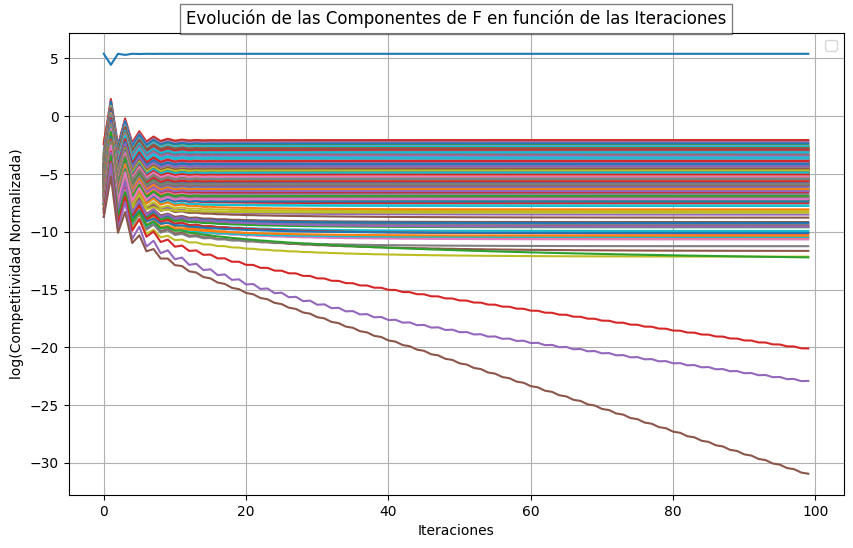

Matriz M:
k          7402        2523        2807        7403        2522       2202  \
i                                                                            
894  730770.726  671472.245  647507.931  395756.413  370479.044  269126.89   
826       0.000       0.000       0.000       0.000       1.000       1.00   
251       0.000       0.000       0.000       0.000       1.000       1.00   
156       0.000       0.000       1.000       0.000       0.000       0.00   
528       0.000       0.000       0.000       0.000       0.000       1.00   
..          ...         ...         ...         ...         ...        ...   
232       0.000       0.000       0.000       0.000       0.000       0.00   
540       0.000       0.000       0.000       0.000       0.000       0.00   
520       0.000       0.000       0.000       0.000       0.000       0.00   
324       0.000       0.000       0.000       0.000       0.000       0.00   
148       0.000       0.000       0.000       0.000   

In [13]:
# Representar la evolución de las componentes de F en función de las iteraciones
plt.figure(figsize=(10, 6))
logaritmo = 1 # Cambiar a 0 para escala lineal
if logaritmo == 1: # Representación en escala logarítmica.
    for j in range(c):
        plt.plot(range(n), np.log(F_valores[:, j]))
    plt.ylabel('log(Competitividad Normalizada)')
else:
    for j in range(c):
        plt.plot(range(n), F_valores[:, j])
    plt.ylabel('Competitividad Normalizada')

plt.xlabel('Iteraciones')
plt.title('Evolución de las Componentes de F en función de las Iteraciones', bbox=dict(facecolor="white", alpha=0.5))
plt.legend()
plt.grid(True)
plt.show()

# Resultados finales de un año.
print("Matriz M:")
print(M)
print("F:")
print(F)
print("Q:")
print(Q)

In [14]:
# Crear un DataFrame con el vector F y las cabeceras de las filas de M
df_F = pd.DataFrame(F, index=M.index, columns=[year])

In [15]:
# Guardar el DataFrame en un archivo CSV, añadiendo como una nueva columna si el archivo ya existe
try:
    existing_df = pd.read_csv('vector_F.csv', index_col=0)
    # Alinear los valores de df_F con el índice de existing_df
    aligned_df_F = df_F.reindex(existing_df.index)
    existing_df[year] = aligned_df_F[year]
    existing_df.to_csv('vector_F.csv', index=True, header=True)
except FileNotFoundError:
    df_F.to_csv('vector_F.csv', index=True, header=True)

Representación de la red compleja.

In [ ]:
# Extraer los elementos de las primeras 10 filas y columnas de la matriz M
mM = np.array(M.iloc[:10, :10])

[[7.30770726e+05 6.71472245e+05 6.47507931e+05 3.95756413e+05
  3.70479044e+05 2.69126890e+05 2.36227555e+05 1.70438124e+05
  1.30565196e+05 1.29292167e+05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 1.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 1.00000000e+00 0.00000000e+00
  1.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e

In [30]:

# Crea un grafo no dirigido
G = nx.Graph()

# Nombres de los 10 primeros países
countries = [str(x) for x in list(M.index[:10])]
# Nombres de los 10 primeros productos
products = list(M.columns[:10])

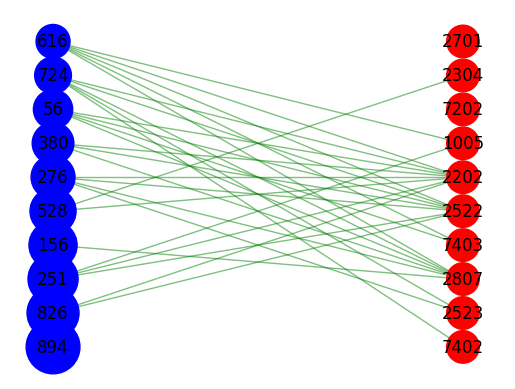

In [38]:
# Añade los nodos (países y códigos) al grafo
for país in countries:
    G.add_node(country)
for product in products:
    G.add_node(product)

# Añade las aristas al grafo basado en la matriz de adyacencia
for i in range(len(countries)):
    for j in range(len(products)):
        if mM[i][j] == 1:
            G.add_edge(countries[i], products[j])

# Colores para los nodos (puedes ajustar esto según tus preferencias)
node_colors = ['b'] * len(countries) + ['r'] * len(products)

# Tamaño de los nodos
node_sizes = [1500 - 100 * i if node in countries else 1000 - 50 * j for i, node in enumerate(G.nodes())]

# Posicionamiento de los nodos (puedes probar con diferentes algoritmos de colocación)
pos = nx.bipartite_layout(G, countries)

# Dibuja el grafo
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, edge_color='green', alpha=0.5)
nx.draw_networkx_labels(G, pos)

# Muestra la gráfica
plt.axis('off')
plt.show()

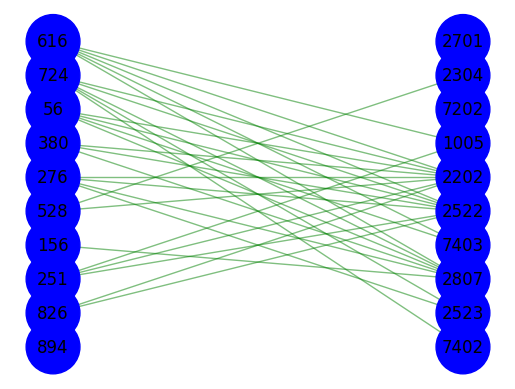

In [28]:
# Añade los nodos (países y códigos) al grafo
for país in countries:
    G.add_node(country)
for product in products:
    G.add_node(product)

# Añade las aristas al grafo basado en la matriz de adyacencia
for i in range(len(countries)):
    for j in range(len(products)):
        if mM[i][j] == 1:
            G.add_edge(countries[i], products[j])

# Colores para los nodos (puedes ajustar esto según tus preferencias)
node_colors = ['b' if isinstance(node, str) else 'r' for node in G.nodes()]
# Tamaño de los nodos (puedes ajustar esto según tus preferencias)
node_sizes = [1500 if isinstance(node, str) else 1000 for node in G.nodes()]

# Posicionamiento de los nodos en dos columnas (bipartite layout)
pos = nx.bipartite_layout(G, countries)

# Dibuja el grafo
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, edge_color='green', alpha=0.5)
nx.draw_networkx_labels(G, pos)

# Muestra la gráfica
plt.axis('off')
plt.show()